# Homework 3

We first import the needed libraries and set the elements we need for the rest of the Homework.

In [1]:
# Used to look for the saved data
IMAGE_FOLDER = 'Data/Images/'
DATA_EUROPE = 'Data/une_rt_a.xls'
DATA_SWITZERLAND = 'Data/chomage.xlsx'
#DATA_SWITZERLAND_BY_AGE = 'Data/chomage_age.xlsx'
#DATA_SWITZERLAND_BY_NATIONALITY = 'Data/chomage_nationalite.xlsx'
DATA_SWITZERLAND_BY_NATIONALITY = 'Data/chomage_etrangers.xlsx'
DATA_SWITZERLAND_BY_AGE = 'Data/chomage_age_nat_2.xlsx'

In [2]:
swiss_geo_path = r'topojson/ch-cantons.topojson.json'
europe_geo_path = r'topojson/europe.topojson.json'

In [3]:
# Importing libraries
import os #might not be useful
import json #might not be useful
import folium
import pandas as pd
import pickle as pkl
import seaborn as sns #might not be useful
from IPython.display import Image #allows showing images
from IPython.display import IFrame #see maps in github
import matplotlib.pyplot as plt
%matplotlib inline

## Unemployment in Europe

The very first thing we have to think about is what data we want to use. Eurostat has a lot of types of information, even more so, has information per country, but also per province/state of some countries (known as NUTS 2 regions). Thus, we have to determine what kind of information - and how much - we want to show.

Thus, we decide to take the **yearly** average for the unemployment rates and not the monthly ones, thus getting data from 2016 and not from 2017. For the monthly rates, we could have information for the beginning of this year, but we decide against it, as will not give an accurate picture due to seasonal changes in unemployment (think of tourism industy etc.). Choosing the yearly average allows us to not have to deal with any fluctuation due to seasonal workers that would not be seen as unemployed for a time.

Secondly, seeing as the idea is to compare the unemployment rate of Europe to that of Switzerland, it would be more appropriate to take the data by country rather than that per NUTS 2 region, even more so seeing as Switzerland is cut in several in that dataset. So, to be able to compare it to Switzerland as a whole, we should have Switzerland as only one entity.

Therefore, we also need data that includes Switzerland, as it is not always the case for all files about unemployment in Europe. Thus, we had to dig a bit deeper and find data on unemployment according to age, sex and nationality (which contains rates for Switzerland, compared to data in the main indicators), which restricts it to people of age 15 to 74. This is actually what we want as those are the "adults" that could be potentially working already, and people that are younger or older should not count in our rates, as they aren't part of the working force.

Note that we also choose to delete all the columns we do not need (years other than 2016) and the data for the UE as a whole, which were the 4 first rows, on the website –before downloading the data.

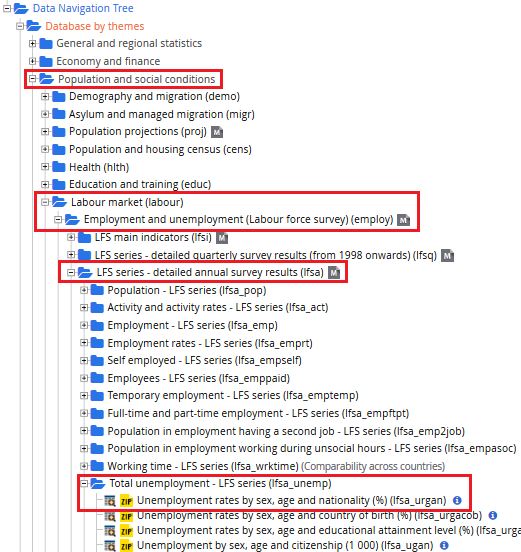

In [4]:
Image(IMAGE_FOLDER + 'euro01.png')

We also had the option to download the data in several different types of files, like HTML, CSV, TSV or XLS. We choose to download the data in a XLS format.

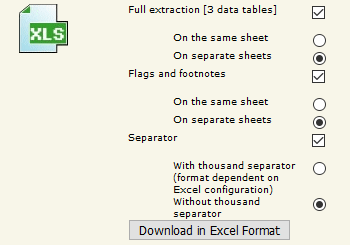

In [5]:
Image(IMAGE_FOLDER + 'euro02.png')

In [6]:
europe_unemployed = pd.read_excel(DATA_EUROPE, header=10)

In [7]:
europe_unemployed.head()

,GEO/TIME,2016
0,Belgium,7.8
1,Bulgaria,7.6
2,Czech Republic,4.0
3,Denmark,6.2
4,Germany (until 1990 former territory of the FRG),4.1


As we can see, we thus have the name in the country and the rate for 2016. The default column names are a bit confusing, so we will quickly change this.

In [8]:
europe_unemployed.columns = ['Country', 'Rate']

We also need to change the names of two countries, as we need to have "Germany" and "The former Yugoslav Republic of Macedonia" instead of "Germany (until 1990 former territory of the FRG)" and "Former Yugoslav Republic of Macedonia, the".

In [9]:
europe_unemployed = europe_unemployed.replace({"Germany (until 1990 former territory of the FRG)": "Germany",
                     "Former Yugoslav Republic of Macedonia, the": "The former Yugoslav Republic of Macedonia"})

In [10]:
europe_unemployed.head()

,Country,Rate
0,Belgium,7.8
1,Bulgaria,7.6
2,Czech Republic,4.0
3,Denmark,6.2
4,Germany,4.1


Now that this is done, we want to have a map of Europe with the given tiles already ready. As we all know, Switzerland is in the middle of Europe, so we're going to give the coordinates for the middle of Switzerland to have the map centered on.

In [11]:
central_swiss_coord = [46.484, 8.1336] 
m_europe = folium.Map(location=central_swiss_coord, zoom_start=4, tiles='cartodbpositron')
m_europe.choropleth(open(europe_geo_path),
             data=europe_unemployed,
             threshold_scale=[3, 4.5, 5.5, 8, 13, 18],
             columns=('Country', 'Rate'),
             legend_name='Unemployment rate (%)',
             fill_color='YlOrBr',
             fill_opacity= 0.8,
             key_on = 'feature.properties.NAME',
             topojson='objects.europe')
m_europe.save('Europe_Map.html')
m_europe

In [57]:
IFrame('Europe_Map.html', width=800, height=600)

As we can see, for the countries we have no data on, the color that was chosen as default is an eggshell white. It is thus easy to see that the countries we have no information about are those not in the UE or in Schengen (Russia, Belarus, Bosnia, ...).

We also choose to change the Threshold so that we can easily see the rates that are different from Switzerland (lower mostly).

Here we can see that Switzerland farers a lot better than most of it's neighboring countries except for Germany (and the Czech Republic) which has a lower rate. Iceland seems to be pretty well off too. Switzerland also has the same rates as the United Kingdom, Norway or Hungary.  

Thus, in terms of unemployment, Switzerland is one of the copuntries with the lowest rate, but not the only one to fare so well.

It is also important to note that, even with us changing the threshold, the colors are a little bit misleading because of the way that choropleth maps reduce the threshold to six numbers. Thus, we have any country with rating between 8 and 13 that have the same color, while also having the same color for countries between ratings 5 and 6, which is a much smaller step.

## Unemployment in Switzerland

In this exercise, we need several elements from the online data provided on the [amstat website](https://www.amstat.ch/v2/index.jsp). Each information we retrieve should be provided for every Swiss canton. To explain our methodology, we will include a print screen of each step we performed. As these steps are self-explanatory, we will not include any furter explanation on our methodology (however, the use of the retrieved data will be tackled in each question).

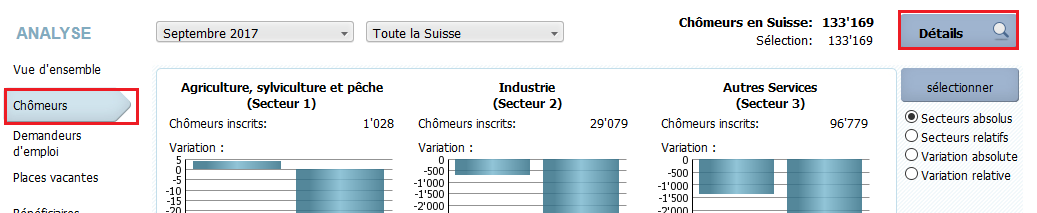

In [12]:
Image(IMAGE_FOLDER + 'amstat01.png')

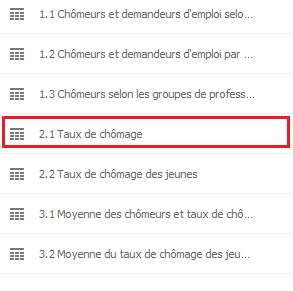

In [13]:
Image(IMAGE_FOLDER + 'amstat02.png')

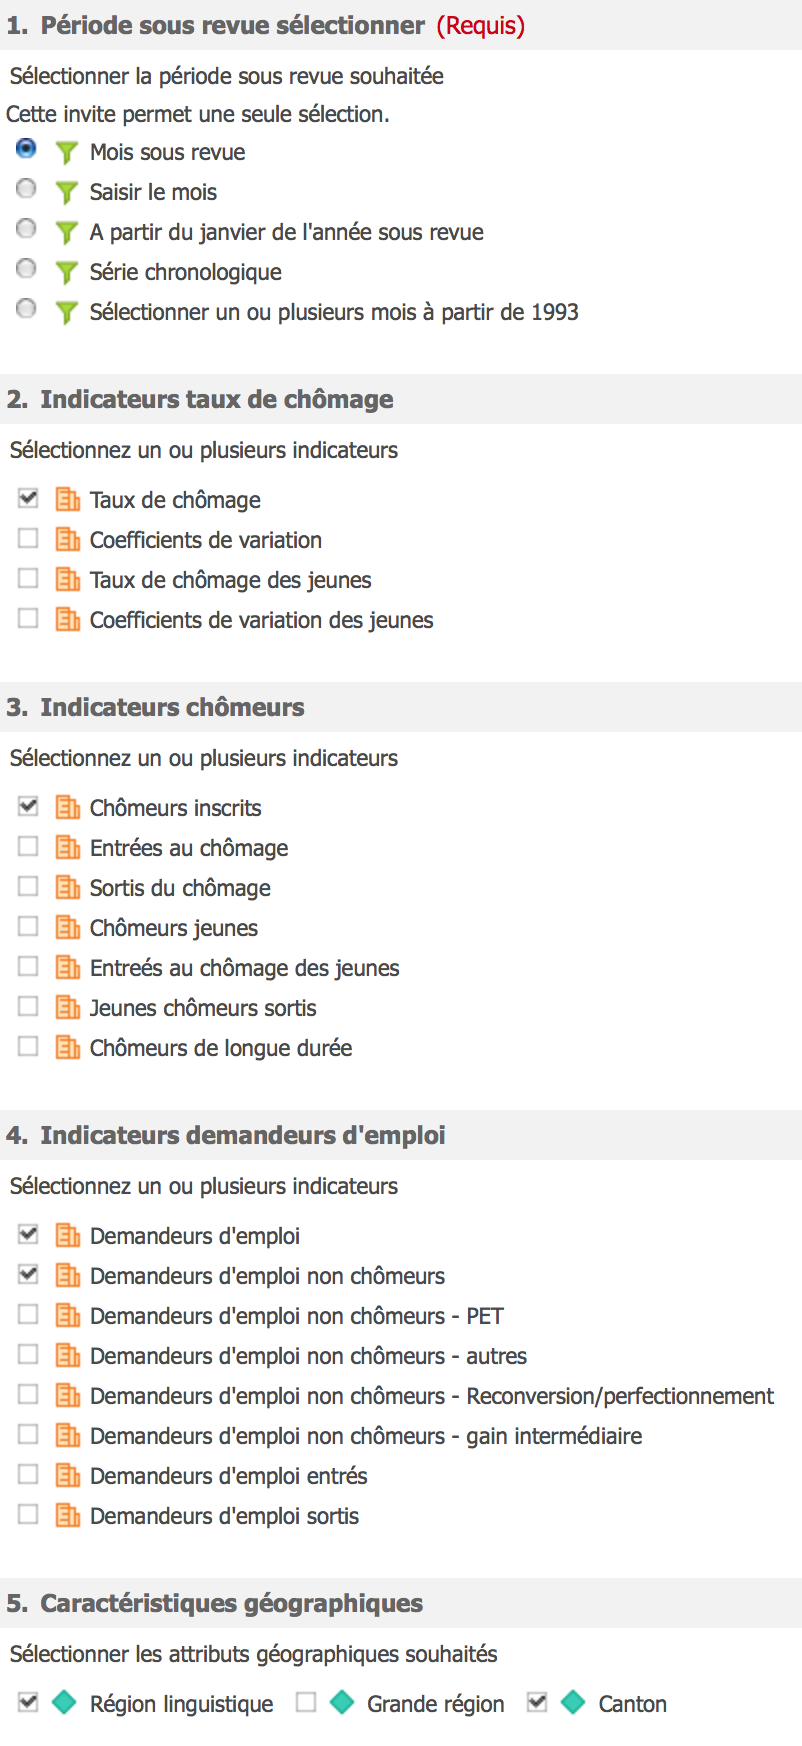

In [14]:
Image(IMAGE_FOLDER + 'amstat03.png', retina = True)

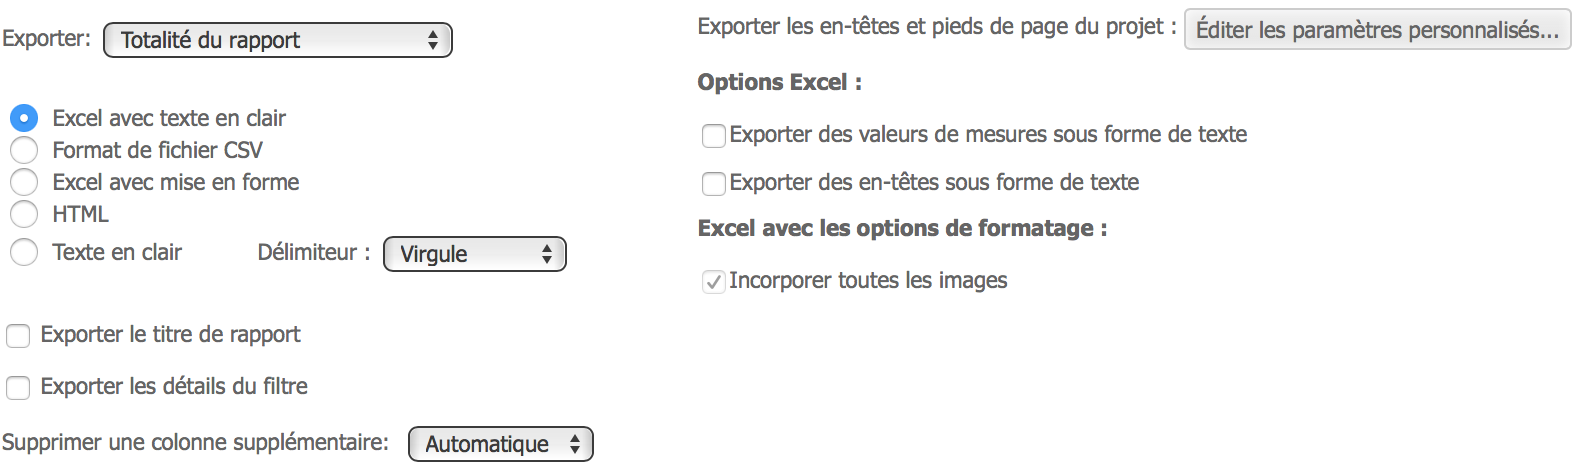

In [15]:
Image(IMAGE_FOLDER + 'amstat04.png', retina = True)

Once we retrieve our data using an XLS file, we still need to perform sanitizing steps before being able to draw our map:
- Deleting useless columns (and rows)
- Getting rid of the Multiindex
- Mapping each canton to its code (vital to draw our map)

In [16]:
swiss_unemployment= pd.read_excel(DATA_SWITZERLAND, header=[0,1])
del swiss_unemployment['Mois'] #Only NaN values
del swiss_unemployment['Total'] #Same as 'Septembre 2017' as we only choose one month
swiss_unemployment.dropna(inplace=True) #We only need the values of each canton, not nationally

In [17]:
swiss_unemployment.columns = [c[-1] for c in swiss_unemployment.columns] #flatten structure
swiss_unemployment.reset_index(inplace=True)
swiss_unemployment.rename(columns={'Unnamed: 0_level_1':'Canton'}, inplace=True)
swiss_unemployment.head()

,index,Canton,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
0,Suisse alémanique,Zurich,3.3,27225,34156,6931
1,Suisse alémanique,Berne,2.4,13658,18385,4727
2,Suisse alémanique,Lucerne,1.7,3885,6756,2871
3,Suisse alémanique,Uri,0.6,112,257,145
4,Suisse alémanique,Schwyz,1.7,1455,2229,774


In this part, we use a special dictionary defined in order to map each canton to its code. You can look at the [mapping](mapping.ipynb) in order to get more information on how we did that.

In [18]:
dico = pkl.load(open('Data/map_cantons.pkl', 'rb'))
swiss_unemployment.insert(1, 'Code', swiss_unemployment['Canton'].map(dico))
swiss_unemployment.head()

,index,Code,Canton,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
0,Suisse alémanique,ZH,Zurich,3.3,27225,34156,6931
1,Suisse alémanique,BE,Berne,2.4,13658,18385,4727
2,Suisse alémanique,LU,Lucerne,1.7,3885,6756,2871
3,Suisse alémanique,UR,Uri,0.6,112,257,145
4,Suisse alémanique,SZ,Schwyz,1.7,1455,2229,774


In order to get meaningful results and to be able to compare both maps, we define a special scale that we can use on both maps. We choose to start with 0.2, the smallest value of unemployment in the 2nd map, and end with 4.2 and 5.2, the highest unemployment rates of each dataset we will study. The remaining scale becomes obvious to determine.

In [19]:
scale = [0.2, 1.2, 2.2, 3.2, 4.2, 5.2]

### Unemployement rate of each Swiss canton

In the first question of Exercise 2, we simply plot the unemployment rate provided by the website (namely using the number of people looking for a job who either currently have a job or not).

In [52]:
swiss_unemployment_map = folium.Map(location=[46.85, 8.23], zoom_start=8, tiles='cartodbpositron')
swiss_unemployment_map.choropleth(open(swiss_geo_path), data=swiss_unemployment,
             columns=['Code', 'Taux de chômage'],
             key_on='feature.id',
             topojson = 'objects.cantons',
             threshold_scale = scale,
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (%)')
swiss_unemployment_map.save('swiss_unemployment_map.html')
swiss_unemployment_map

We can see very intereseting trends by looking at the map. We will not dwell on the (very apparent) Röstigraben, which we will tackle at the end of our homework. However, we can clearly see that the highest unemployment rates are found in urban french-speaking cantons (Geneva, Vaud, Neuchatel, Jura and Basel-City). We can also see a high rate in Zurich as it is a very urban city (leading to less employment).

When looking at the cantons with the least unemployment (< 2.2%), we can see 2 clear trends explaining this : their economy is largely based on agriculture and industry and they have a very small population (only Lucerne and Thurgau have over 200K inhabitants).

### Unemployement rate (of people without a job) of each Swiss canton

In this question we will focus on the "real" unemployment rate of people who currently do not have a job (which seems more sound than looking at people who do have a job but are simply looking for a new one). However, to be able to do that, we first need to determine the actual unemployment rate.

When trying to compute the active population of each canton, we found results differing from those of the [Federal Statistical Office](https://www.bfs.admin.ch/bfs/en/home.html). Even though these numbers are not up to date, we decided to try another method to calculate the rate : we first calculate the rate of people without a job and multiply it by the total rate of unemployed people.

In [21]:
real_swiss_unemployment = swiss_unemployment
del real_swiss_unemployment['Demandeurs d\'emploi non chômeurs']
real_swiss_unemployment['Taux de chômage'] = (real_swiss_unemployment['Chômeurs inscrits']/ 
                real_swiss_unemployment['Demandeurs d\'emploi'])*real_swiss_unemployment['Taux de chômage']
real_swiss_unemployment.head()

,index,Code,Canton,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi
0,Suisse alémanique,ZH,Zurich,2.630358,27225,34156
1,Suisse alémanique,BE,Berne,1.782932,13658,18385
2,Suisse alémanique,LU,Lucerne,0.977575,3885,6756
3,Suisse alémanique,UR,Uri,0.261479,112,257
4,Suisse alémanique,SZ,Schwyz,1.109690,1455,2229


In [53]:
real_swiss_unemployment_map = folium.Map(location=[46.85, 8.23], zoom_start=8, tiles='cartodbpositron')
real_swiss_unemployment_map.choropleth(open(swiss_geo_path), data=real_swiss_unemployment,
             columns=['Code', 'Taux de chômage'],
             key_on='feature.id',
             topojson = 'objects.cantons',
             threshold_scale = scale,
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of (real) unemployment (%)')
real_swiss_unemployment_map.save('real_swiss_unemployment_map.html')
real_swiss_unemployment_map

On top of seeing the same trends as the map above, we have a clear decline in the unemployment rates (all cantons' unemployment rate decreased by at least 1% on the map) where most of the rural german-speaking cantons have the lowest unemployment rate. This is once again very easily explained as people in more urban cantons are more prone to be interested in other jobs.

### Differences in unemployment between foreigners and natives

Here we have two different questions again: one about the difference in employment regarding nationality, and the second regarding age. We proceed to the amstat website and select the following categories:

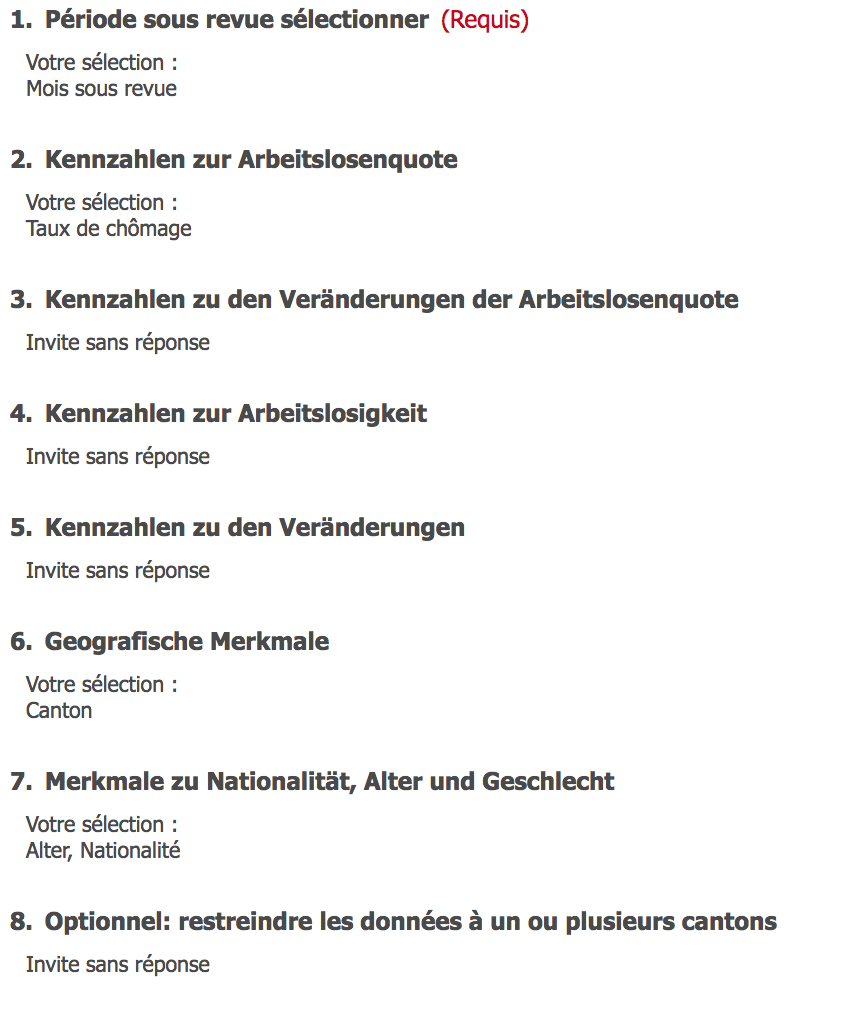

In [23]:
Image(IMAGE_FOLDER + 'categories_q3.png', width='450px')

After the selection we are asked to specifiy the age range: we choose to use 3 categories

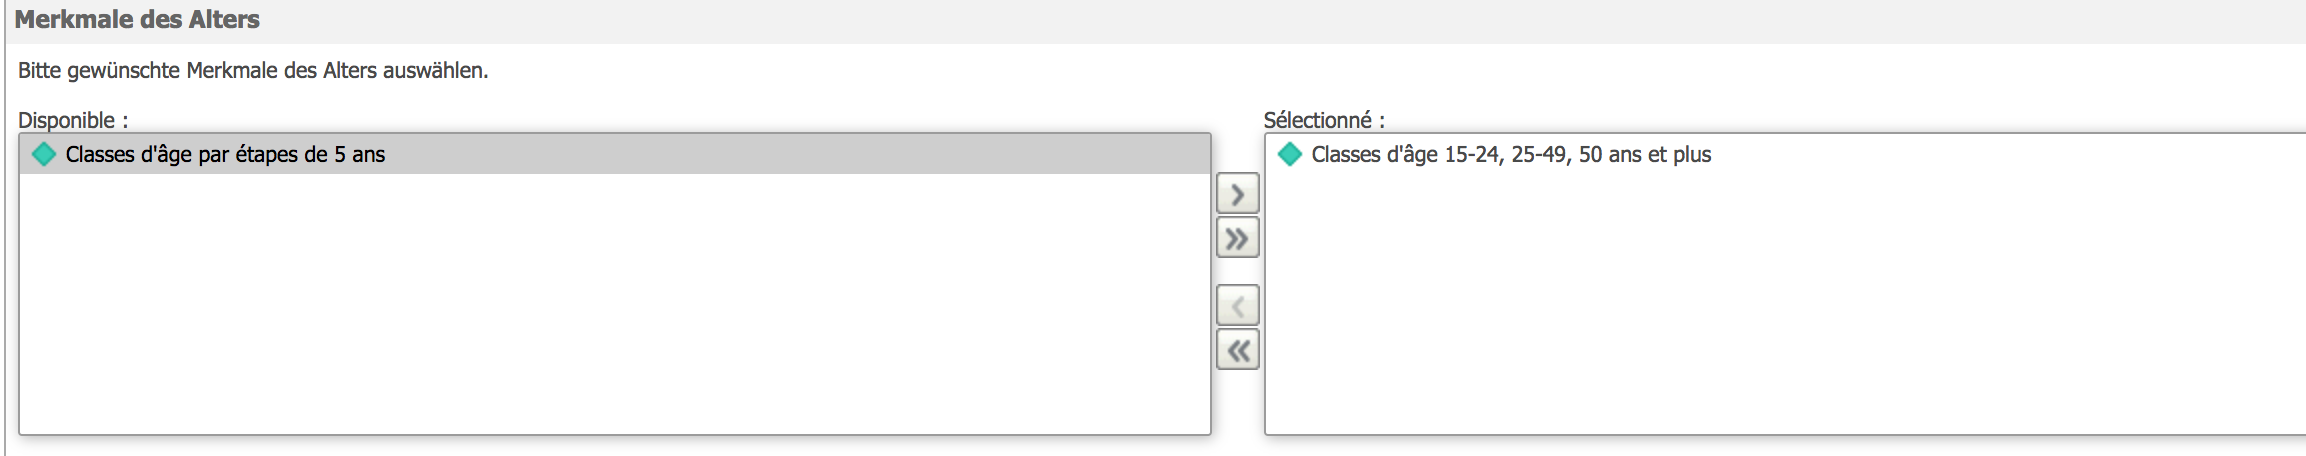

In [24]:
Image(IMAGE_FOLDER + 'age_selection.png')

After having selected out criteria we can further pivot and unpivot the rows using the websites tools:

We start out with the following allignment. By clicking on the pivot button we can change this lignup to have 2 columns, one for foreigners and one for swiss nationals

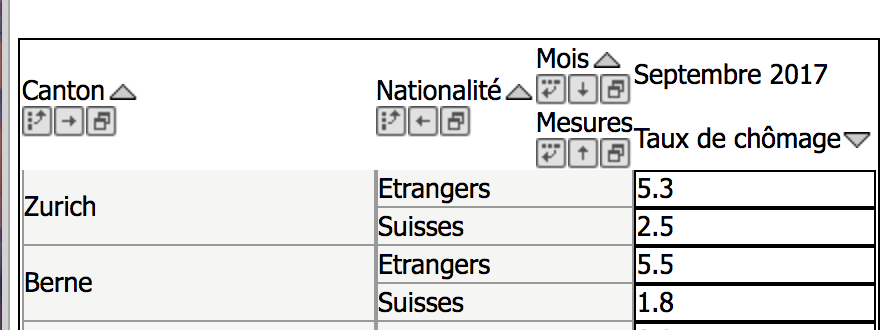

In [25]:
Image(IMAGE_FOLDER + 'foreigners_1.png', width='450px')

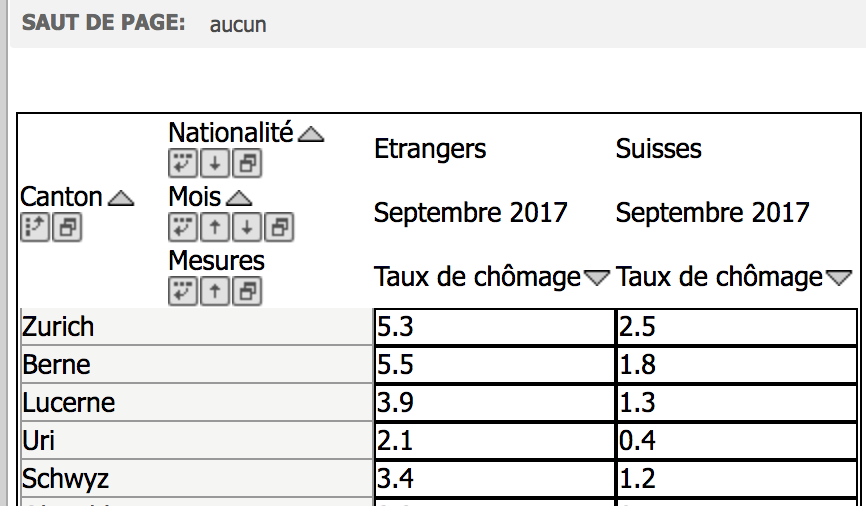

In [26]:
Image(IMAGE_FOLDER + 'foreigners_2.png', width='450px')

We can use this set up without having to preform transformations on the columns.

We import the data set downloaded previously.
We only need to flatten some of the structure.

In [27]:
swiss_foreign_unemployed = pd.read_excel(DATA_SWITZERLAND_BY_NATIONALITY, header=[0,2])

In [28]:
del swiss_foreign_unemployed['Nationalité'] ##remove Measures column
swiss_foreign_unemployed.columns = swiss_foreign_unemployed.columns.droplevel(1) ##remove redunant multiindex
swiss_foreign_unemployed.reset_index(inplace=True) #we need to do this for later

In [29]:
swiss_foreign_unemployed.head()

Canton,index,Etrangers,Suisses
0,Zurich,5.3,2.5
1,Berne,5.5,1.8
2,Lucerne,3.9,1.3
3,Uri,2.1,0.4
4,Schwyz,3.4,1.2


To later easely map the values in the dataframe to the shapes as provided in the topojson we preform a mapping, as before:

In [30]:
swiss_foreign_unemployed['Code'] = swiss_foreign_unemployed['index'].map(dico)

We calculate different measures to look at the difference between unemploment between two groups. The difference (scaled by the sum of both unemploment rates) and the rate both show different trends.

The ratio gives us how many times higher the unemployment rate for foreigners is compared to swiss people.
The difference / total rate gives us the difference taking into consideration how high unemployment is in general in that canton.

In [31]:
total = swiss_foreign_unemployed['Etrangers'] #+ swiss_foreign_unemployed['Suisses'] #this should be oths general data
swiss_foreign_unemployed['Difference'] = (swiss_foreign_unemployed['Etrangers'] - swiss_foreign_unemployed['Suisses']) / total
swiss_foreign_unemployed['Ratio'] = swiss_foreign_unemployed['Etrangers'] / swiss_foreign_unemployed['Suisses']

In [32]:
swiss_foreign_unemployed.head()

Canton,index,Etrangers,Suisses,Code,Difference,Ratio
0,Zurich,5.3,2.5,ZH,0.528302,2.120000
1,Berne,5.5,1.8,BE,0.672727,3.055556
2,Lucerne,3.9,1.3,LU,0.666667,3.000000
3,Uri,2.1,0.4,UR,0.809524,5.250000
4,Schwyz,3.4,1.2,SZ,0.647059,2.833333


We first look at the ratio. We can observe that the difference between the unemploment rate is smaller in urbanized areas such as Geneva or Zurich and bigger in rural areas, such as Uri and Glarus. 
Looking at the absolute rates, we see that areas with high disparities have very low rates of unemployment in general. 

In [55]:
swiss_foreign_map = folium.Map(location=[46.85, 8.23], zoom_start=8, tiles='cartodbpositron')
swiss_foreign_map.choropleth(open(swiss_geo_path),
             data=swiss_foreign_unemployed,
             columns=('Code', 'Ratio'),
             legend_name='Ratio in unemployment (%)',
             fill_opacity=0.7, line_opacity=0.2,
             fill_color='OrRd',
             key_on = 'feature.id',
             topojson='objects.cantons')
swiss_foreign_map.save('swiss_foreign_map_ratio.html')
swiss_foreign_map

Here we highlight the places where, the difference relative to total unemployment is big. This is an attempt to take absolute value of unemployment into consideration. It is very hard to draw conclusions for this as we are already working with percentages.

In [56]:
swiss_foreign_map = folium.Map(location=[46.85, 8.23], zoom_start=8, tiles='cartodbpositron')
swiss_foreign_map.choropleth(open(swiss_geo_path),
             data=swiss_foreign_unemployed,
             columns=('Code', 'Difference'),
             legend_name='Difference in unemployment (%)',
             fill_opacity=0.7, line_opacity=0.2,
             fill_color='OrRd',
             key_on = 'feature.id',
             topojson='objects.cantons')
swiss_foreign_map.save('swiss_foreign_map_diff.html')
swiss_foreign_map

### Differences in unemployment between swiss and foreign workers by age groups

Getting this dataset was harder, as one had to select the correct links to be able to get the data by age and nationality at the same time.

Here we show the path we used:
We had to click on monthly reports, and then get the unemploment rate by different categories.
By using this path we get complete control over what data we want.

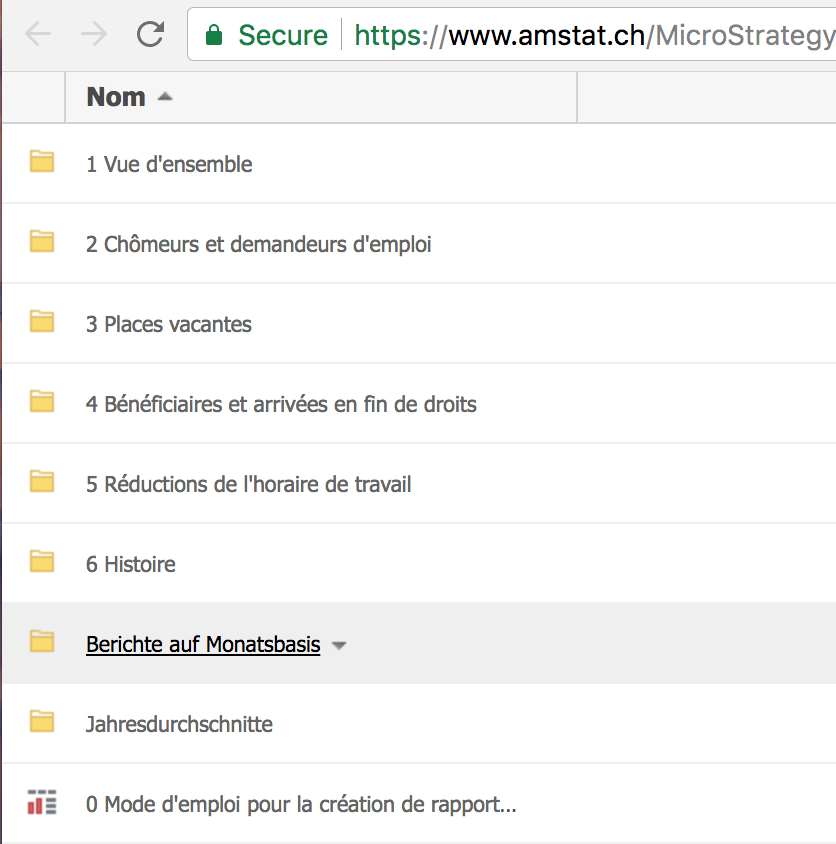

In [35]:
Image(IMAGE_FOLDER + 'find_folder.png', width='300px')

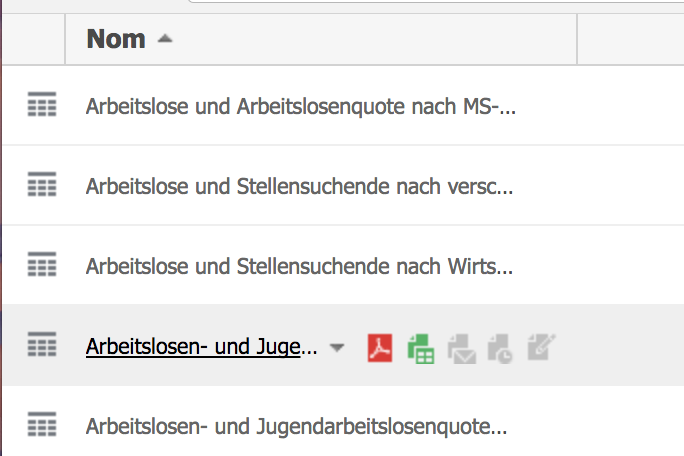

In [36]:
Image(IMAGE_FOLDER + 'find_folder_2.png', width='300px')

We now read the data into a dataframe. Note that for some cantons, some values are not present, and marked by '...'. We transform these values into NaN as to be able to more easly handle them.

In [37]:
swiss_unemployed_age = pd.read_excel(DATA_SWITZERLAND_BY_AGE, header=[0,1], na_values='...') 

swiss_unemployed_age.columns = swiss_unemployed_age.columns.droplevel(1)
del swiss_unemployed_age["Mois"] #remove empty line

In [38]:
swiss_unemployed_age['Code'] = swiss_unemployed_age.index.to_series().map(dico)
swiss_unemployed_age.reset_index(inplace=True)

In [39]:
swiss_unemployed_age.head() #what looks like 2 columns is 1 :S

Canton,index,Nationalité,"Classes d'âge 15-24, 25-49, 50 ans et plus","Classes d'âge 15-24, 25-49, 50 ans et plus",Septembre 2017,Code
0,Zurich,Etrangers,1,15-24 ans,5.8,ZH
1,Zurich,Etrangers,2,25-49 ans,5.1,ZH
2,Zurich,Etrangers,3,50 ans et plus,5.8,ZH
3,Zurich,Suisses,1,15-24 ans,3.2,ZH
4,Zurich,Suisses,2,25-49 ans,2.5,ZH


In [40]:
#renaming columns for convenience
swiss_unemployed_age.columns = ['index', 'Nationalité', 'Category Name',
       "Age class: 15-24, 25-49, 50 ans and up", 'Unemployment rate', 'Code']

In [41]:
del swiss_unemployed_age['Category Name']

In the exercise we are asked to draw a bar plot. We found that, even with a bar plot, it is quite hard to get a good overview of the data. In our first attempt we plot two different barplots.
We found that using the Canton as the x axis gives the most readable charts, as otherwise the Cantons are color coded.

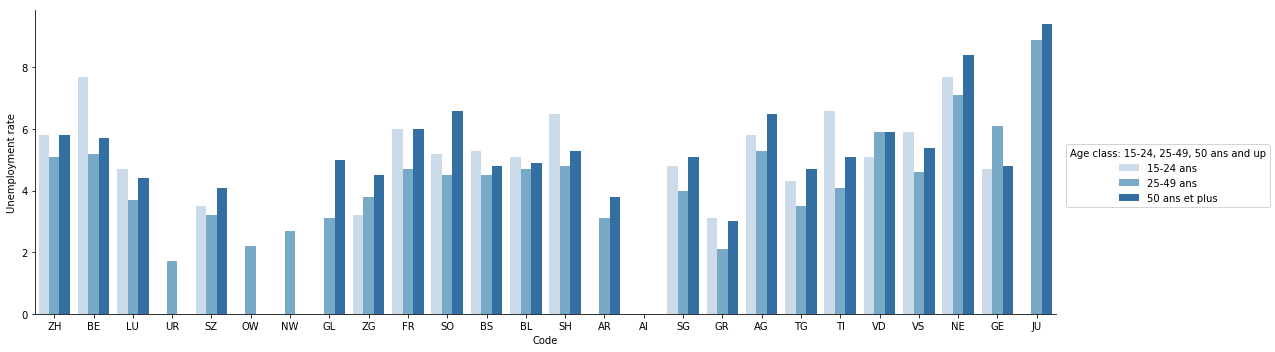

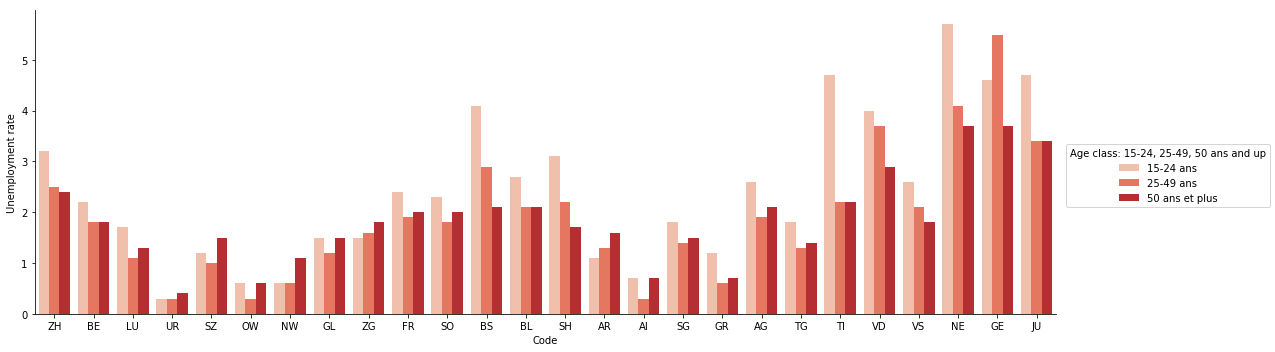

In [42]:
#yet to find good plot
sns.factorplot(#col="Nationalité", 
                   y='Unemployment rate', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=swiss_unemployed_age[swiss_unemployed_age['Nationalité'] == 'Etrangers'],
                   kind="bar",     
                   palette="Blues", size=5, aspect=3)
sns.factorplot(#col="Nationalité", 
                   y='Unemployment rate', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=swiss_unemployed_age[swiss_unemployed_age['Nationalité'] == 'Suisses'],
                   kind="bar",     
                   palette="Reds", size=5, aspect=3)

In the next plot I overlay the two. In blue, we see the rates for foreigners in different age groups, in red the same for swiss nationals.

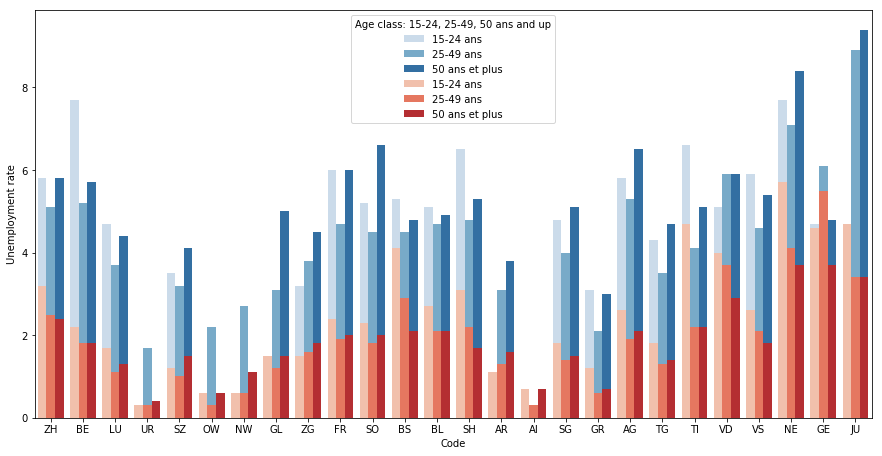

In [43]:
plt.figure(figsize=(15,7.5))
g = sns.barplot(y='Unemployment rate', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=swiss_unemployed_age[swiss_unemployed_age['Nationalité'] == 'Etrangers'], 
                   palette="Blues")
sns.barplot(y='Unemployment rate', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=swiss_unemployed_age[swiss_unemployed_age['Nationalité'] == 'Suisses'], 
                   palette='Reds'
           )

We again observe that a lot of elderly foreigners are more unemployed. 
For both groups young people have the highest unemployment rate.
In some cantons younger people suffer much higher rates of unemployment.

In an other attempt to better visualize this, we use the ratio instead. 
Next you will find the manipulations necessary to calculate the ration for all age.

In [44]:
#pivot df for easier manipulation
pivoted_unemployment = pd.pivot_table(data=swiss_unemployed_age, values='Unemployment rate',
               columns=['Nationalité', 'Age class: 15-24, 25-49, 50 ans and up'], 
               dropna=False,
               index = 'index'
              ).reset_index()

In [45]:
#preform division
suisses = pivoted_unemployment['Suisses']
etrangers = pivoted_unemployment['Etrangers']
barplot = etrangers.divide(suisses)
barplot['Code'] = swiss_foreign_unemployed['Code']

In [46]:
#un-pivot colummn (easier for visualisation)
barplot = barplot.melt(id_vars='Code')

This figure displays quite well the discrepancies. We see that sadly some of the interesting cases do not have data for all age classes.
We see that in most cantons the ratio is most different for the group 50+, followed by the group 25-49. The group 15-24 in general has the smallest ration - that means foreign and swiss workers in this group show similar unemployment rates.
But we note that for some rural areas, such as Uri, Nidwalden and Wallis young people have a higher ratio than their older groups. This could be due to the type of employment offered in these areas.  

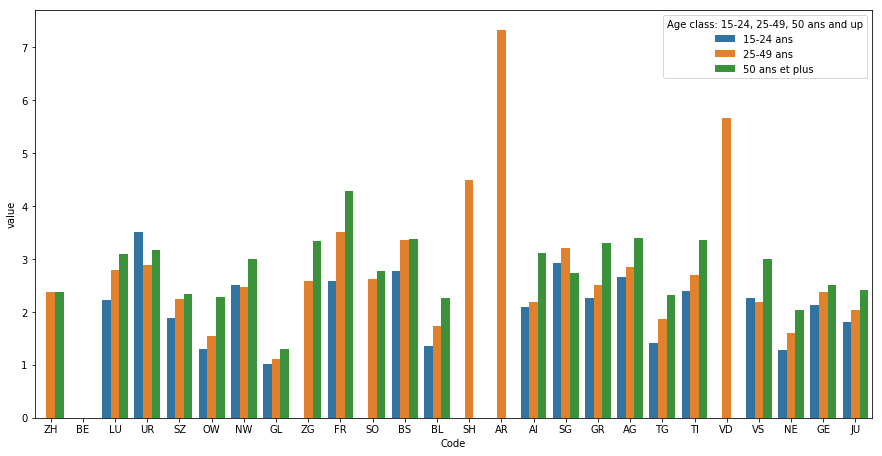

In [47]:
plt.figure(figsize=(15,7.5))
g = sns.barplot(y='value', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=barplot)

Finaly we decide to also show the distribution over all cantons using boxplots, which gives a better overview without looking at Cantons individualy.

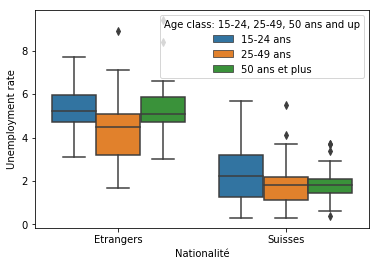

In [48]:
sns.boxplot(x='Nationalité', 
            y='Unemployment rate', 
            hue='Age class: 15-24, 25-49, 50 ans and up', data=swiss_unemployed_age)

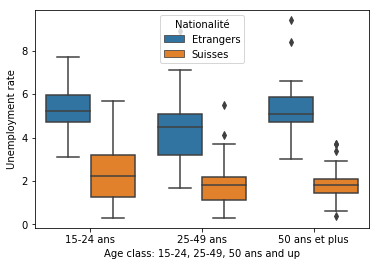

In [49]:
sns.boxplot(hue='Nationalité', 
            y='Unemployment rate', 
            x='Age class: 15-24, 25-49, 50 ans and up', data=swiss_unemployed_age)

We again see that the discrepancy between the foreigners and swiss nationals is largest for the age group 50 and above.
We note that, while for swiss nationals, the youngest group is the most unemployed followed by the two older groups being similarly yet slightly more employed. For foreigners, the elderly have a higher unemployment rate than the middlea-ged group.

### The Röstigraben

In [50]:
swiss_unemployment_map

The Röstigraben, a cultural gap between german and french speaking Switzerland, is very visible in our analysis.
We note that the french-speaking part of Switzerland has more unemployment but has a smaller gap between foreigners and swiss nationals while the german-speaking trends are inversed.
We estimate the difference in unemployment rates between the areas divided by the Röstigraben to be around 2% when looking at the choropleth map.